In [2]:
# Connect to MongoDB
import pymongo
from pymongo import MongoClient

# Connect to the localhost client
client = MongoClient()

# Get the petfinder database
db = client.petfinder_database
collection = db.pets

In [3]:
# Total size of the collection.
collection.estimated_document_count()

135440

In [4]:
# Total size of collection without an image
collection.count_documents({"url_img":{"$eq":""}})

6295

In [5]:
# Store collection into Pandas DataFrame
import pandas as pd
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

query = {}
cursor = collection.find(query)
df =  pd.DataFrame(list(cursor))
# Delete the _id
del df['_id']

df.head(4)
df.size
df[0:1]

,desc,id,state,type,url,url_img
0,"MO - Bandit, adoptable Dog, Puppy Male Bullma...",41500599,MO,DOG,https://www.petfinder.com/dog/mo-bandit-415005...,https://dl5zpyw5k3jeb.cloudfront.net/photos/pe...


In [6]:
df1 = df.groupby(["type"] ).size().to_frame(name = 'count').reset_index()

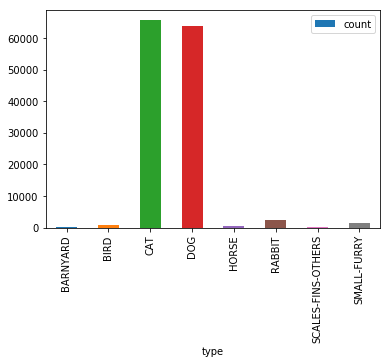

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
df1.plot(kind='bar', y='count', x='type')


In [8]:
df1 = df.groupby(["type"] ).size().to_frame(name = 'count').reset_index()

In [9]:
# Explore the description
df2 = df["desc"]
df2.head()

0    MO  - Bandit, adoptable Dog, Puppy Male Bullma...
1    Axel, adoptable Cat, Kitten Male Domestic Shor...
2    Art, adoptable Cat, Kitten Male Domestic Short...
3    Alf, adoptable Cat, Kitten Male Domestic Short...
4    Ari, adoptable Cat, Kitten Male Domestic Short...
Name: desc, dtype: object

In [14]:
import re

def substitute(keywords):
    rep = {
        "&": "and",
        "(": "",
        ")": "",
        "/":"",
        "'":"",
        ".":"",
        "`":"",
        ",":""
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))
    
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], keywords)

In [15]:
agg_type = set()
agg_breed = set()

def desc_parse(record):
    keyword = 'adoptable '
    before_keyword, keyword, after_keyword = record.partition(keyword)
    # clean and sanitize the string
    clean = substitute(after_keyword)
    split = clean.split(' ')
    
    # First Record is Type of Pet
    pet_type = split[0]
    
    # Second Record is the Age
    age = split[1]
    
    # Third record is the Gender
    gender = split[2]
    
    # Records are Breed
    breed = " ".join(split[3:])
    
    agg_type.add(pet_type)
    agg_breed.add(breed)
    
    return pet_type, age, gender, breed
    
    
df2.apply(desc_parse)
# print("-- Types --")
# print(agg_type)
print("-- Breeds --")
print(len(agg_breed))
# agg_breed

-- Breeds --
4561


In [16]:
def requestImage(src):
    uu = str(uuid.uuid4())
    req = urllib.request.Request(
        src,
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/542.36'
        }
    )
    with urllib.request.urlopen(req) as response, open('./img-dog/'+uu+'.jpg', 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

    return uu

In [37]:
collection.count_documents({"type":"CAT","url_img":{"$ne":""}})

61915

In [36]:
# Create a CSV file with image URIs and labels
import csv
f = open('dog_labels.csv', 'w')
with f:
    fieldnames = ['pet']
    writer = csv.DictWriter(f, fieldnames=fieldnames, quoting = csv.QUOTE_NONE, delimiter='|', quotechar='')
    writer.writeheader()
    
    for doc in collection.find({"type":"DOG", "state":"MO","url_img":{"$ne":""}}).limit( 1244 ):
        pet_type, age, gender, breed = desc_parse(doc['desc'])

        base_str = "gs://ociautomltest-vcm/{0}.jpg,{1}"
    
#         entry = base_str.format(doc['id'], breed.replace(" ", "_"))
        entry = base_str.format(doc['id'], age)
        
        writer.writerow({'pet': entry})
#         writer.writerow(entry)
#     requestImage(doc['url_img'])

# df.info()
# gs://ociautomltest-vcm/flowers/images/5217892384_3edce91761_m.jpg,dandelion,tulip,rose

In [ ]:
# # Create a new DataFrame for the agg_breed
# df_breed = pd.DataFrame(list(agg_breed),columns=['breed'])
# df_breed.size
# df_breed.head()
# # df_breed.info

# #List unique values in the df['name'] column

# num_breeds = df_breed.breed.unique()
# len(num_breeds)


# df_breed.plot(kind='line', x='breed')

## Topic Modeling with Scikit Learn
Latent Dirichlet Allocation (LDA) is a algorithms used to discover the topics that are present in a corpus. A few open source libraries exist, but if you are using Python then the main contender is Gensim. Gensim is an awesome library and scales really well to large text corpuses. Gensim, however does not include Non-negative Matrix Factorization (NMF), which can also be used to find topics in text. The mathematical basis underpinning NMF is quite different from LDA. I have found it interesting to compare the results of both of the algorithms and have found that NMF sometimes produces more meaningful topics for smaller datasets. NMF has been included in Scikit Learn for quite a while but LDA has only recently (late 2015) been included. The great thing about using Scikit Learn is that it brings API consistency which makes it almost trivial to perform Topic Modeling using both LDA and NMF. Scikit Learn also includes seeding options for NMF which greatly helps with algorithm convergence and offers both online and batch variants of LDA.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

documents = agg_breed

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 3
display_topics(nmf, tfidf_feature_names, no_top_words)
print('-----')
display_topics(lda, tf_feature_names, no_top_words)